<a href="https://colab.research.google.com/github/vishal-burman/PyTorch-Architectures/blob/master/research/modeling_VariationalAutoEncoder/test_sample_VariationalAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/vishal-burman/PyTorch-Architectures.git
%cd PyTorch-Architectures/research/modeling_VariationalAutoEncoder/

fatal: destination path 'PyTorch-Architectures' already exists and is not an empty directory.
/content/PyTorch-Architectures/research/modeling_VariationalAutoEncoder


In [2]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from model_vae import VariationalAutoEncoder

if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: ', device)

# Hyperparameters
RANDOM_SEED = 0
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
BATCH_SIZE = 128

# Architecture
NUM_FEATURES = 784
NUM_HIDDEN_1 = 500
NUM_LATENT = 15

Device:  cpu


In [4]:
#################
# MNIST Dataset
#################

train_dataset = datasets.MNIST(root="data",
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)
valid_dataset = datasets.MNIST(root="data",
                               train=False,
                               transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

# Sanity check
for images, labels in train_loader:
  print('Image Dimensions: ', images.shape)
  print('Label Dimensions: ', labels.shape)
  break

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!

Image Dimensions:  torch.Size([128, 1, 28, 28])
Label Dimensions:  torch.Size([128])


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
torch.manual_seed(RANDOM_SEED)
model = VariationalAutoEncoder(NUM_FEATURES, NUM_HIDDEN_1, NUM_LATENT)
model.to(device)

VariationalAutoEncoder(
  (hidden_1): Linear(in_features=784, out_features=500, bias=True)
  (z_mean): Linear(in_features=500, out_features=15, bias=True)
  (z_log_var): Linear(in_features=500, out_features=15, bias=True)
  (linear_3): Linear(in_features=15, out_features=500, bias=True)
  (linear_4): Linear(in_features=500, out_features=784, bias=True)
)

In [6]:
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Trainable Parameters: ', params)

Trainable Parameters:  808314


In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [8]:
start_time = time.time()
for epoch in range(NUM_EPOCHS):
  for batch_idx, (features, targets) in enumerate(train_loader):
    features = features.view(features.size(0), -1).to(device)

    z_mean, z_log_var, encoded, decoded = model(features)

    # Cost = reconstruction loss + Kullback-Leibler Divergence
    kl_divergence = (0.5 * (z_mean ** 2 + torch.exp(z_log_var) - z_log_var - 1)).sum()
    pixel_wise_bce = F.binary_cross_entropy(decoded, features, reduction='sum')
    cost = kl_divergence + pixel_wise_bce

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    # LOGGING
    if batch_idx % 50 == 0:
      print('Batch: %04d/%04d || Epoch: %04d/%04d || Loss: %.2f' % (batch_idx, len(train_loader), epoch+1, NUM_EPOCHS, cost.item()))
  epoch_elapsed_time = (time.time() - start_time) / 60
  print('Epoch Elapsed Time: %.2f min' % (epoch_elapsed_time))
total_training_time = (time.time() - start_time) / 60
print('Total Training Time: %.2f min' % (total_training_time))

Batch: 0000/0469 || Epoch: 0001/0050 || Loss: 70444.58
Batch: 0050/0469 || Epoch: 0001/0050 || Loss: 26604.30
Batch: 0100/0469 || Epoch: 0001/0050 || Loss: 21923.13
Batch: 0150/0469 || Epoch: 0001/0050 || Loss: 19611.25
Batch: 0200/0469 || Epoch: 0001/0050 || Loss: 19099.20
Batch: 0250/0469 || Epoch: 0001/0050 || Loss: 17970.02
Batch: 0300/0469 || Epoch: 0001/0050 || Loss: 17392.75
Batch: 0350/0469 || Epoch: 0001/0050 || Loss: 17194.93
Batch: 0400/0469 || Epoch: 0001/0050 || Loss: 16493.34
Batch: 0450/0469 || Epoch: 0001/0050 || Loss: 16321.28
Epoch Elapsed Time: 0.23 min
Batch: 0000/0469 || Epoch: 0002/0050 || Loss: 16294.99
Batch: 0050/0469 || Epoch: 0002/0050 || Loss: 15787.23
Batch: 0100/0469 || Epoch: 0002/0050 || Loss: 15395.05
Batch: 0150/0469 || Epoch: 0002/0050 || Loss: 14999.94
Batch: 0200/0469 || Epoch: 0002/0050 || Loss: 15344.42
Batch: 0250/0469 || Epoch: 0002/0050 || Loss: 15911.94
Batch: 0300/0469 || Epoch: 0002/0050 || Loss: 14832.90
Batch: 0350/0469 || Epoch: 0002/0050

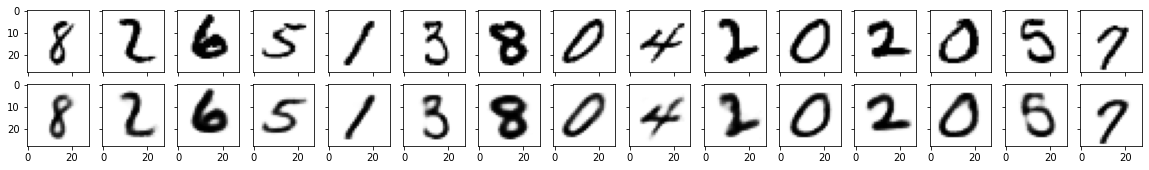

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')